In [1]:

import tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Layer ,Conv2D,Conv2DTranspose,DepthwiseConv2D,Conv3D,LeakyReLU
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,SeparableConv2D
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout,ReLU,Conv2D, Activation,Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D,Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import time
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
np.random.seed(42)
from sklearn.model_selection import train_test_split

tf.compat.v1.disable_eager_execution()

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(32)
tf.__version__


'2.1.0'

In [2]:
# Load and resize the training and testing images
train_RGB=[]
train_semseg=[]
idx=1

# Set directory pointer
source_train_path='E:/future trials/SYNTHIA-AL/train/'
source_test_path='E:/future trials/SYNTHIA-AL/test/'
   
        
for imaget in os.listdir(source_train_path):
    source2_train_path='E:/future trials/SYNTHIA-AL/train/'+imaget+'/'
    for imaget2 in os.listdir(source2_train_path):
        source3_train_path=source2_train_path+imaget2+'/'+'RGB'+'/'
        print(source3_train_path)
        for imaget4 in os.listdir(source3_train_path):
            image_train=cv2.imread(source3_train_path+imaget4)
            #image_train = cv2.cvtColor(image_train, cv2.COLOR_BGR2RGB)    # in case of RGB tet images
            image_train1=cv2.resize(image_train,(256,128))
            train_RGB.append(image_train1)
  
           
for imaget in os.listdir(source_train_path):
    source2_train_path='E:/future trials/SYNTHIA-AL/train/'+imaget+'/'
    for imaget2 in os.listdir(source2_train_path):
        source3_train_path=source2_train_path+imaget2+'/'+'SemSeg'+'/'
        print(source3_train_path)
        for imaget4 in os.listdir(source3_train_path):
            semseg_train=cv2.imread(source3_train_path+imaget4)
            semseg_train = cv2.cvtColor(semseg_train, cv2.COLOR_BGR2GRAY)
            semseg_train=cv2.resize(semseg_train,(256,128))
            train_semseg.append(semseg_train)


E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_0_spawn_1_roadTexture_1_P_None_C_None_B_None_WC_None/19-10-2018_12-47-37/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_0_spawn_1_roadTexture_2_P_None_C_None_B_None_WC_None/19-10-2018_12-32-19/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_2_spawn_1_roadTexture_1_P_None_C_None_B_None_WC_None/19-10-2018_13-33-29/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_2_spawn_1_roadTexture_2_P_None_C_None_B_None_WC_None/19-10-2018_13-52-10/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_3_spawn_0_roadTexture_0_P_None_C_None_B_None_WC_None/23-10-2018_0-03-58/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_3_spawn_1_roadTexture_2_P_None_C_None_B_None_WC_None/22-10-2018_22-54-58/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_3_spawn_2_roadTexture_1_P_None_C_None_B_None_WC_None/22-10-2018_23-17-34/RGB/
E:/future trials/SYNTHIA-AL/train/test5_10segs_weather_3_spawn_2_roadT

In [3]:
# Check the length of training set
print(len(train_RGB))

5600


In [4]:
# Data normalization and tensorflow preparation

train_RGB=np.array(train_RGB)/255.
train_RGB=train_RGB.astype(np.float32)

train_semseg=np.array(train_semseg)/255.
train_semseg = tf.convert_to_tensor(train_semseg, dtype=tf.float32)

train_semseg=tf.expand_dims(train_semseg, axis=-1)
with tf.compat.v1.Session() as sess: train_semseg=    (train_semseg).eval()
    
# Print the shape of the prepared training set    
print(train_semseg.shape)

(5600, 128, 256, 1)


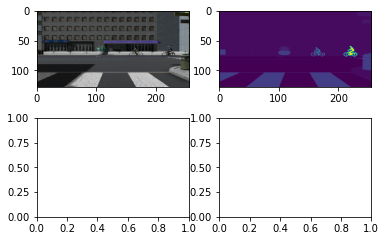

In [5]:
# Plot an image and its corresponding segmentation mask 
tot=train_RGB[998]
tot_plot=train_semseg[998]
f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(tot)
axarr[0][1].imshow(tot_plot[0:,:])

In [7]:
# For sake of computation, we consider only the training set as the whole data set and we split it into x_train and X_test
x_train,x_test,y_train,y_test=train_test_split(train_RGB,train_semseg,test_size=0.25,random_state=42)


In [8]:
# Learning weights reducer to search and fine-tune the parameters
def ler_scheducal(epoch):
    # it takes the  epoch as integer and returns learning rate in float32 format
    ler=1e-3
    if epoch>650:   ## you can chang it to be >150 for ddep  model learning
        ler*=0.5e-3
    elif epoch > 300:  ## you can chang it to be >130 for ddep  model learning
        ler*=1e-3
    elif epoch>150: ## you can chang it to be >100 for ddep  model learning
        ler*=1e-2
    elif epoch >50:
        ler*=1e-1
    print('The leearninig rate is:  ',ler)
    return ler

c=ler_scheducal(2)
print(c)


The leearninig rate is:   0.001
0.001


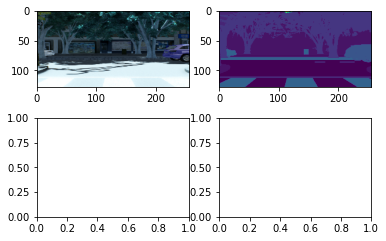

In [9]:
# Final plot of the split training data and its corresponding masktot=x_train[3000]
tot_plot=y_train[3000]
f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(tot)
axarr[0][1].imshow(tot_plot[0:,:])

In [10]:
#Mgrad2VAE architecture and compiling

#Input
img_rows, img_cols, img_chns = 128, 256, 3
#latent space length
latent_dim =256
intermediate_dim = 1024
epsilon_std = 1.0
epochs = 100
filters = 8
num_conv = 3
batch_size = 8


# alternative gradient function can be used
def grad( y, x ):
  return Lambda( lambda z: K.gradients( z[ 0 ], z[ 1 ] ), output_shape = z[1])( [ y, x ] )


# tensorflow uses channels_last
# theano uses channels_first
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

################################################################################################### Encoder ##############################################

# Encoder architecture
x = Input(shape=original_img_size)

# Another input for a supervised labelling: in which we compute the difference between the GT  reconstructed mask, and attention map.
xx = Input(shape=(128, 256, 1))



conv_1 = Conv2D( filters,
               kernel_size=(3, 3),
              padding='same',  kernel_initializer='he_uniform',activation='relu')(x)

conv_2 = Conv2D(filters*2,
                kernel_size=(3, 3),
                padding='same',  kernel_initializer='he_uniform',activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters*3,
                kernel_size=(3, 3),
                padding='same',  kernel_initializer='he_uniform',activation='relu',
                strides=(2, 2))(conv_2)
conv_4 = Conv2D(filters*4,
                kernel_size=(3, 3),
                padding='same',  kernel_initializer='he_uniform',activation='relu',
                strides=(2, 2))(conv_3)
                
flat = Flatten()(conv_4)
                
hidden = Dense(intermediate_dim,  kernel_initializer='he_uniform',activation='relu')(flat)

# Mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Compute the second gradient between the latent space and the last encoding layer
grads0  = tensorflow.gradients(z, conv_4)
grads00  = tensorflow.gradients(grads0, conv_4)
grads00=tf.squeeze(grads00)
final_grad0_0=tf.reshape(grads00,(-1,16,32, filters*4))

final_grad0_0=LeakyReLU(alpha=0.3)(final_grad0_0)


# Scale and learn the gradient estimated between the latent space and the last encoding layer
final_grad0 = Conv2DTranspose(filters*4,
                                           kernel_size=(3, 3),
                                           strides=(4,4),
                                           padding='same',
                                           kernel_initializer='he_uniform',activation='relu')(final_grad0_0)

final_grad_l4 = Conv2DTranspose(filters*4,
                                          kernel_size=(3, 3),
                                          strides=(2,2),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad0)

final_grad_l4 = Conv2DTranspose(filters*4,
                                          kernel_size=(3, 3),
                                          strides=(1,1),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad_l4)



# Compute the second gradient between the latent space and the third encoding layer


grads1  = tensorflow.gradients(z, conv_3)
grads11  = tensorflow.gradients(grads1, conv_3)
grads11=tf.squeeze(grads11)
final_grad1_1=tf.reshape(grads11,(-1,32,64, filters*3))
final_grad1_1=LeakyReLU(alpha=0.3)(final_grad1_1)


# Scale and learn the gradient estimated between the latent space and the third encoding layer

final_grad1 = Conv2DTranspose(filters*3,
                                           kernel_size=(3, 3),
                                           strides=(2,2),
                                           padding='same',
                                           kernel_initializer='he_uniform',activation='relu')(final_grad1_1)

final_grad_l3 = Conv2DTranspose(filters*3,
                                          kernel_size=(3, 3),
                                          strides=(2,2),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad1)


final_grad_l3 = Conv2DTranspose(filters*3,
                                          kernel_size=(3, 3),
                                          strides=(1,1),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad_l3)


# Compute the second gradient between the latent space and the second encoding layer

grads2  = tensorflow.gradients(z, conv_2)
grads22  = tensorflow.gradients(grads2, conv_2)
grads22=tf.squeeze(grads22)
final_grad2_2=tf.reshape(grads22,(-1,64,128, filters*2))
final_grad2_2=LeakyReLU(alpha=0.3)(final_grad2_2)


# Scale and learn the gradient estimated between the latent space and the third encoding layer
final_grad_l2 = Conv2DTranspose(filters*2,
                                          kernel_size=(3, 3),
                                          strides=(2,2),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad2_2)

final_grad_l2 = Conv2DTranspose(filters*2,
                                          kernel_size=(3, 3),
                                          strides=(1,1),
                                          padding='same',
                                          kernel_initializer='he_uniform',activation='relu')(final_grad_l2)





# Compute the second gradient between the latent space and the third encoding layer
grads3  = tensorflow.gradients(z, conv_1)
grads33  = tensorflow.gradients(grads3, conv_1)
grads33=tf.squeeze(grads33)
final_grad3_3=tf.reshape(grads33,(-1,128,256, filters))
final_grad3_3=LeakyReLU(alpha=0.3)(final_grad3_3)

# Scale and learn the gradient estimated between the latent space and the third encoding layer

final_grad_l1 = Conv2DTranspose(filters,
                                           kernel_size=(3, 3),
                                           strides=(1,1),
                                           padding='same',
                                           kernel_initializer='he_uniform',activation='relu')(final_grad3_3)




# Visualize the gradient attention at each encoding layer

# The last layer
final_grad_l4_s = Conv2D(1,
                             kernel_size=1,
                             padding='same',
                             activation='sigmoid')(final_grad_l4)
# The third layer
final_grad_l3_s = Conv2D(1,
                             kernel_size=1,
                             padding='same',
                             activation='sigmoid')(final_grad_l3)

# The second layer
final_grad_l2_s = Conv2D(1,
                             kernel_size=1,
                             padding='same',
                             activation='sigmoid')(final_grad_l2)

# The first layer

final_grad_l1_s = Conv2D(1,
                             kernel_size=1,
                             padding='same',
                             activation='sigmoid')(final_grad_l1)

# Concatinate the gradient attention among all layers
all_concat=tf.concat( [final_grad_l1, final_grad_l2, final_grad_l3,final_grad_l4], axis=-1, name='concat')



all_concat=  Conv2D(filters,
                                          kernel_size=(3, 3),
                                          strides=1,
                                          padding='same',
                                        kernel_initializer='he_uniform',
                                         activation='relu')(all_concat)





# The aggregated and learnable attention map
final4_grad = Conv2D(1,
                                          kernel_size=(1,1),
                                          strides=1,
                                          padding='same',
                                         activation='sigmoid',name="tension_final")(all_concat)






################################################################################################### Decoder ##############################################



# The decoder architecture
decoder_hid = Dense(intermediate_dim,  kernel_initializer='he_uniform',activation='relu')
decoder_upsample = Dense(int(filters *4* img_rows / 8 * img_cols / 8),  kernel_initializer='he_uniform',activation='relu') # 8 can be increseased to the above layer filiter i.e. if in conv 4 filters = 64 then at this lyer it must be equal to 64

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters*4, int(img_rows / 8), int(img_cols / 8))
else:
    output_shape = (batch_size, int(img_rows / 8), int(img_cols / 8), filters*4)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters*4,
                                   kernel_size=(3, 3),
                                   padding='same',
                                   strides=(2, 2),
                                    kernel_initializer='he_uniform',activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters*3,
                                   kernel_size=(3, 3),
                                   padding='same',
                                   strides=(2, 2),
                                    kernel_initializer='he_uniform',activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters*2,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='same',
                                           kernel_initializer='he_uniform',activation='relu')


decoder_deconv_3_upsamp0 = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding='same',
                                           kernel_initializer='he_uniform',activation='relu')





decoder_deconv_3_upsamp1 = Conv2D(filters,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding='same',
                                           kernel_initializer='he_uniform',activation='relu')

decoder_mean_squash0 = Conv2D(3,
                             kernel_size=1,
                             padding='valid',
                             activation='sigmoid')


decoder_mean_squash = Conv2D(1,
                             kernel_size=1,
                             padding='valid',
                             activation='sigmoid')




hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)


reshape_decoded = decoder_reshape(up_decoded)


deconv_1_decoded = decoder_deconv_1(reshape_decoded)

deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)

x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)

x_decoded_relu = decoder_deconv_3_upsamp0(x_decoded_relu)

# Residual fusion
x_decoded_relu = tf.keras.layers.Add()([x_decoded_relu, all_concat])

x_decoded_relu = decoder_deconv_3_upsamp1(x_decoded_relu)

# Residual fusion
x_decoded_relu = tf.keras.layers.Add()([x_decoded_relu, all_concat])


x_decoded_mean_squash = decoder_mean_squash0(x_decoded_relu)

# Residual fusion
x_decoded_relu = tf.keras.layers.Add()([x_decoded_relu, final4_grad])

# The model decoder output
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


################################################################################################### Compile and Build ##############################################

# Custom VAE layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

        
# Vae losses
    def vae_loss(self, x, x_decoded_mean_squash,final4_grad,xx,final_grad_l1_s,final_grad_l2_s,final_grad_l3_s,final_grad_l4_s):
           
# Compute SSIM index
        xx_ssim=xx
        im0_ssim = tf.image.convert_image_dtype(xx_ssim, tf.float32)
        im_reconstruction = tf.image.convert_image_dtype(x_decoded_mean_squash, tf.float32)
        im_attention = tf.image.convert_image_dtype(final4_grad, tf.float32)
        ssim_reconstruction = tf.image.ssim(xx_ssim, im_reconstruction, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_attension = tf.image.ssim(xx_ssim, im_attention, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
# Flat images and the output of attentions modules
        x = K.flatten(x)
        xx = K.flatten(xx)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        final4_grad = K.flatten(final4_grad) 
        final_grad_l3_s=K.flatten(final_grad_l3_s)
        final_grad_l4_s=K.flatten(final_grad_l4_s)
        final_grad_l2_s=K.flatten(final_grad_l2_s)
        final_grad_l1_s=K.flatten(final_grad_l1_s)

# Compute binary cross entropy (reconstruction metric)    
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(xx, x_decoded_mean_squash)
        xent_loss2 = img_rows * img_cols * metrics.binary_crossentropy(xx,final4_grad)
        xent_loss3 = img_rows * img_cols * metrics.binary_crossentropy(xx,final_grad_l1_s)
        xent_loss4 = img_rows * img_cols * metrics.binary_crossentropy(xx,final_grad_l2_s)
        xent_loss5 = img_rows * img_cols * metrics.binary_crossentropy(xx,final_grad_l3_s)
        xent_loss6 = img_rows * img_cols * metrics.binary_crossentropy(xx,final_grad_l4_s)

# Compute KL divergence
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        total_loss=K.mean(xent_loss + kl_loss)
        total_loss2=K.mean(xent_loss2 + kl_loss)
        total_loss3=K.mean(xent_loss3 + kl_loss)
        total_loss4=K.mean(xent_loss4 + kl_loss)
        total_loss5=K.mean(xent_loss5 + kl_loss)
        total_loss6=K.mean(xent_loss6 + kl_loss)

    
        return [xent_loss,xent_loss2,kl_loss,total_loss,total_loss2,total_loss3,total_loss4,total_loss5,total_loss6,ssim_reconstruction,ssim_attension]
    

# Call compiling fuction 
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        final4_grad = inputs[2]
        xx = inputs[3]  
        final_grad_l1_s = inputs[4]
        final_grad_l2_s = inputs[5]
        final_grad_l3_s = inputs[6]
        final_grad_l4_s = inputs[7]

        


        loss1,loss2,loss3,loss5,loss6,loss7,loss8,loss9,loss10,ssim_reconstruction,ssim_attension = self.vae_loss(x, x_decoded_mean_squash,final4_grad,xx,final_grad_l1_s,final_grad_l2_s,final_grad_l3_s,final_grad_l4_s)
        self.add_loss(loss5)
        self.add_loss(loss6)
        self.add_loss(loss7)
        self.add_loss(loss8)
        self.add_loss(loss9)
        self.add_loss(loss10)
# The first SSIM reconstruction metric: in the training it will appear as "mean"        
        self.add_metric(tf.keras.metrics.Mean()(ssim_reconstruction),name='metric_1')
    
# The second SSIM attention  metric: in the training it will appear as "metric_2"        
        self.add_metric(tf.math.reduce_mean(ssim_attension),name='metric_2', aggregation='mean')
    
# The first AUC reconstruction metric: in the training it will appear as "auc"        
        self.add_metric(tf.keras.metrics.AUC()([xx],[x_decoded_mean_squash]),name='metric_3')
    
# The second AUC reconstruction metric: in the training it will appear as "auc_1"        
        self.add_metric(tf.keras.metrics.AUC()([xx],[final4_grad]),name='metric_4')

        return x
# The output of variation among all layers    
y = CustomVariationalLayer()([x, x_decoded_mean_squash,final4_grad,xx,final_grad_l1_s,final_grad_l2_s,final_grad_l3_s,final_grad_l4_s])

# entire model compiling
vae = Model([x,xx],y)
vae.compile(optimizer=Adam(lr=ler_scheducal(0)), loss=None)

vae.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The leearninig rate is:   0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 16)  1168        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 24)   3480        conv2d_1[0][0] 

In [11]:
#Define learning rate schedule and reducer
ler_schedular=LearningRateScheduler(ler_scheducal)
ler_reducer= ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=3,min_lr=0.5e-6)

#Prepare the callback for model learnining and saving
callbacks=[ler_schedular,ler_reducer]

#Data augmentation

USE_AUGMENTATION=True
if not USE_AUGMENTATION:
    print('Hey please use teh augmentation')
    model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test,y_test),shuffle=True,callbacks=callbacks)

else:
    print(" Using real time data Augmentation")

    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    
    datagen1 = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen1.fit(y_train)
    
    
    
#model training 
history = vae.fit_generator(datagen.flow([x_train,y_train], batch_size=32),
                        validation_data=([x_test,y_test],None),
                        epochs=750, verbose=2, workers=1,shuffle=True,
                        callbacks=callbacks, use_multiprocessing=False)

 Using real time data Augmentation
Instructions for updating:
Please use Model.fit, which supports generators.
The leearninig rate is:   0.001
Epoch 1/750
Epoch 1/750
1400/132 - 12s - loss: 12960.4119 - mean: 0.6896 - metric_2: 0.6548 - auc: 0.5795 - auc_1: 0.5867
132/132 - 72s - loss: 31444.1357 - mean: 0.6758 - metric_2: 0.5869 - auc: 0.5221 - auc_1: 0.5256 - val_loss: 13088.4028 - val_mean: 0.6896 - val_metric_2: 0.6548 - val_auc: 0.5795 - val_auc_1: 0.5867
The leearninig rate is:   0.001
Epoch 2/750
Epoch 1/750
1400/132 - 11s - loss: 10875.7243 - mean: 0.7023 - metric_2: 0.7400 - auc: 0.7046 - auc_1: 0.6377
132/132 - 65s - loss: 11921.0092 - mean: 0.7591 - metric_2: 0.7220 - auc: 0.6118 - auc_1: 0.5979 - val_loss: 11117.8044 - val_mean: 0.7023 - val_metric_2: 0.7400 - val_auc: 0.7046 - val_auc_1: 0.6377
The leearninig rate is:   0.001
Epoch 3/750
Epoch 1/750
1400/132 - 12s - loss: 9760.9419 - mean: 0.8673 - metric_2: 0.8533 - auc: 0.7289 - auc_1: 0.6522
132/132 - 65s - loss: 10380.

(1, 128, 256, 3)


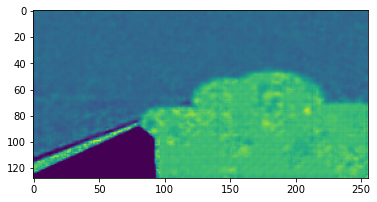

In [559]:

# Visualization after training

image_show=x_test[76]
mask_show=y_test[76]

# Must expand the dimesion for evaluation
test_image = np.expand_dims(image_show, axis=0)
print(test_image.shape)


# Testing the output of the reconstruction and the aggregated attention module
encoder0=Model(x,final4_grad)
encoder1=Model(x,final_grad_l4_s)
encoder2=Model(x,x_decoded_mean_squash)


# Predict the testing image
gradient0= encoder0.predict(test_image, batch_size=batch_size)
gradient1=encoder1.predict(test_image,batch_size=batch_size)
gradient2=encoder2.predict(test_image,batch_size=batch_size)


gradient0=tf.squeeze(gradient0)    
gradient1=tf.squeeze(gradient1)
gradient2=tf.squeeze(gradient2)


with tf.compat.v1.Session() as sess: show_grad0=    (gradient0).eval()

with tf.compat.v1.Session() as sess: show_grad1=    (gradient1).eval()

with tf.compat.v1.Session() as sess: reconstruction=    (gradient2).eval()

# Plot the reconstruction of the decoder module
plt.imshow(reconstruction)


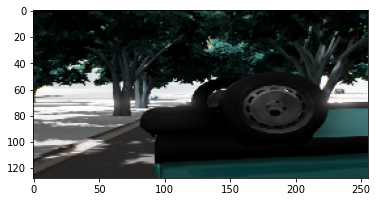

In [561]:
# Plot the original image
plt.imshow(image_show)

(1, 128, 256, 3)


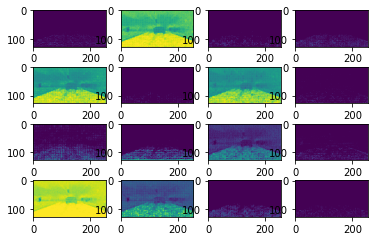

In [136]:

# Show the final attention as a function as filter depth
image_show=train_RGB[7]
test_image = np.expand_dims(image_show, axis=0)
print(test_image.shape)


encoder7=Model(x,final_grad_l4)
gradient7= encoder7.predict(test_image, batch_size=batch_size)


gradient7=tf.nn.sigmoid(gradient7)
gradient7=tf.squeeze(gradient7)    

with tf.compat.v1.Session() as sess: show_grad7=    (gradient7).eval()
    

f, axarr = plt.subplots(4,4)
axarr[0][0].imshow(show_grad7[:,:,0])
axarr[0][1].imshow(show_grad7[:,:,1])
axarr[0][2].imshow(show_grad7[:,:,2])
axarr[0][3].imshow(show_grad7[:,:,3])
axarr[1][0].imshow(show_grad7[:,:,4])
axarr[1][1].imshow(show_grad7[:,:,5])
axarr[1][2].imshow(show_grad7[:,:,6])
axarr[1][3].imshow(show_grad7[:,:,7])
axarr[2][0].imshow(show_grad7[:,:,8])
axarr[2][1].imshow(show_grad7[:,:,9])
axarr[2][2].imshow(show_grad7[:,:,10])
axarr[2][3].imshow(show_grad7[:,:,11])
axarr[3][0].imshow(show_grad7[:,:,12])
axarr[3][1].imshow(show_grad7[:,:,13])
axarr[3][2].imshow(show_grad7[:,:,14])
axarr[3][3].imshow(show_grad7[:,:,15])


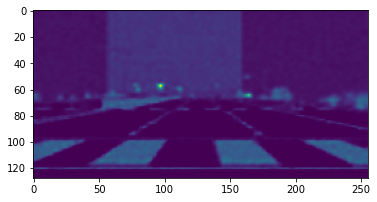

In [104]:
# Final attention plot
plt.imshow(show_mgrad_final)